# model 1: Mobilenet (weak)

## **Overview**

MobileNet is a lightweight and efficient convolutional neural network architecture designed for mobile and embedded vision applications. In this section, we utilize MobileNetV2, a variant of MobileNet, pretrained on the ImageNet dataset. The pretrained MobileNetV2 model is augmented with custom layers to suit our specific classification task.

In [ ]:
# Load MobileNetV2 model with pretrained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Identify the top layers to unfreeze
# Here, we choose to unfreeze the last 20 layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Add custom layers on top of MobileNetV2
x = base_model.output
x = Conv2D(32, (5, 5), activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/AI/ML-Fall2023/project/github/models/v2-unfreez',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)
callbacks = [early_stopping, model_checkpoint]

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

model.save_weights('/content/drive/MyDrive/AI/ML-Fall2023/project/github/models/v2-unfreez')

Epoch 1/200
59/59 [==============================] - ETA: 0s - loss: 2.8477 - accuracy: 0.1134
Epoch 1: val_accuracy improved from -inf to 0.17073, saving model to /content/drive/MyDrive/AI/ML-Fall2023/project/github/models/v2-unfreez
59/59 [==============================] - 33s 362ms/step - loss: 2.8477 - accuracy: 0.1134 - val_loss: 2.6661 - val_accuracy: 0.1707
Epoch 2/200
58/59 [============================>.] - ETA: 0s - loss: 2.4832 - accuracy: 0.1999
Epoch 2: val_accuracy improved from 0.17073 to 0.32927, saving model to /content/drive/MyDrive/AI/ML-Fall2023/project/github/models/v2-unfreez
59/59 [==============================] - 19s 324ms/step - loss: 2.4831 - accuracy: 0.2000 - val_loss: 2.4430 - val_accuracy: 0.3293
Epoch 3/200
58/59 [============================>.] - ETA: 0s - loss: 2.2015 - accuracy: 0.2645
Epoch 3: val_accuracy improved from 0.32927 to 0.40244, saving model to /content/drive/MyDrive/AI/ML-Fall2023/project/github/models/v2-unfreez
59/59 [==================

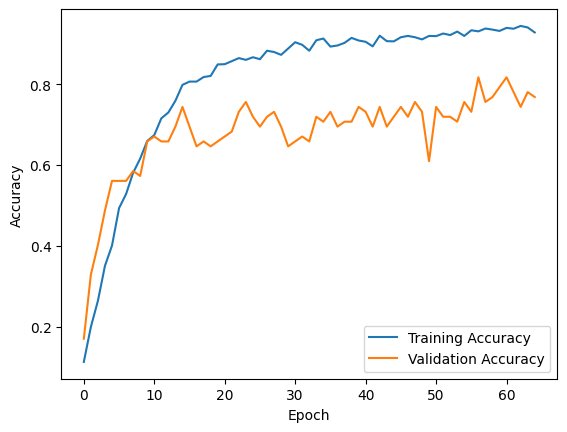

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

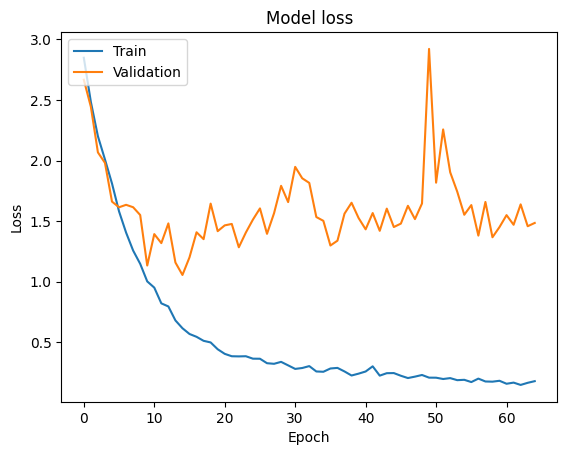

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

3/3 [==============================] - 1s 577ms/step - loss: 1.3835 - accuracy: 0.6265
Test Accuracy: 62.65%


As you see the test and val accuracy is not much good (**test: 63%, val: 80%, train: 94%**)

Let's checkout our wrong predictions to see how bad our model is predicting (can it predict the equal genders?)

3/3 [==============================] - 0s 49ms/step


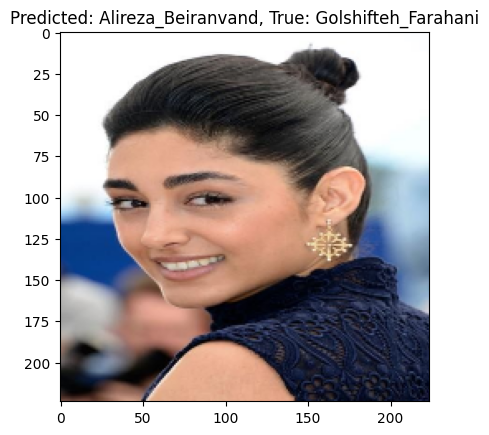

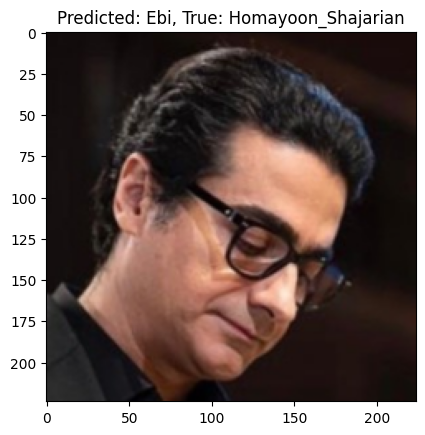

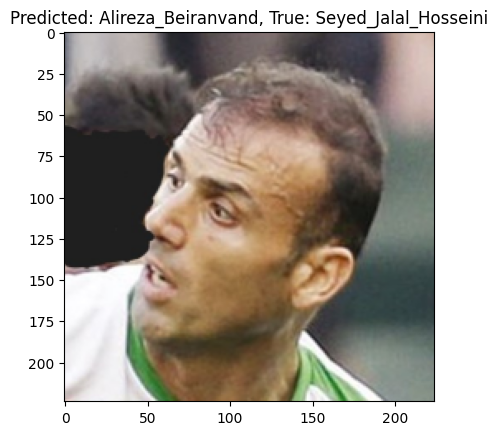

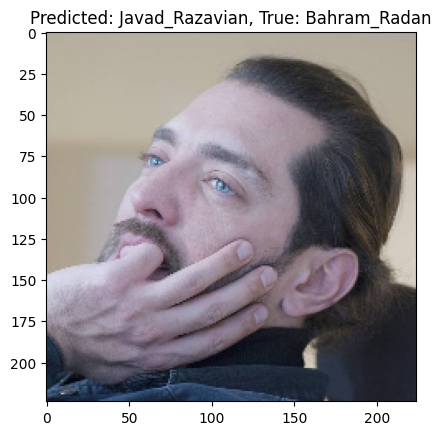

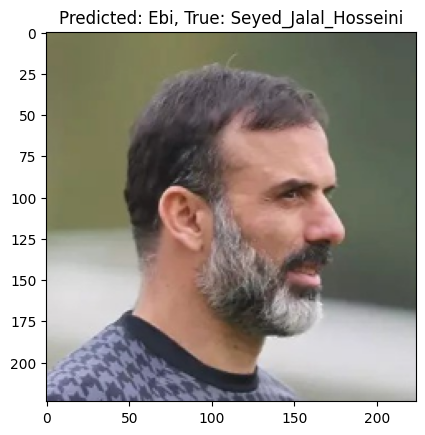

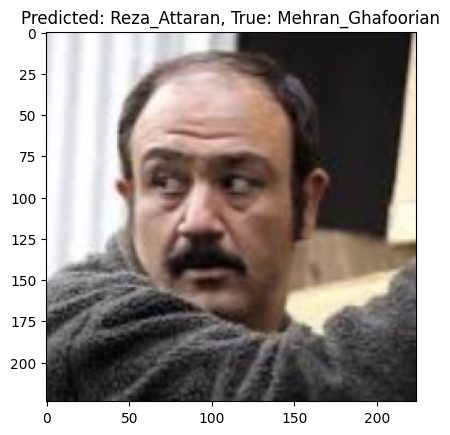

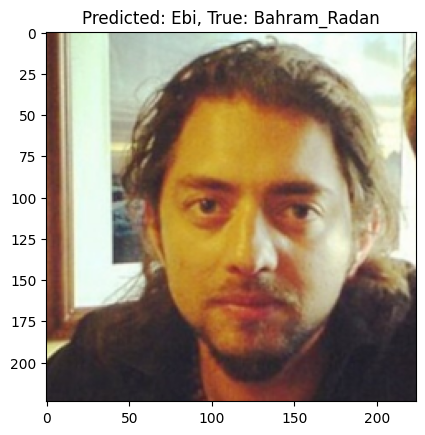

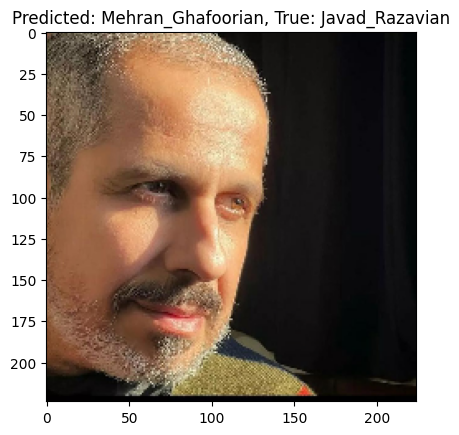

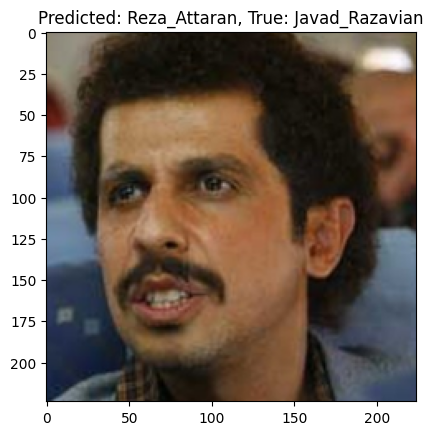

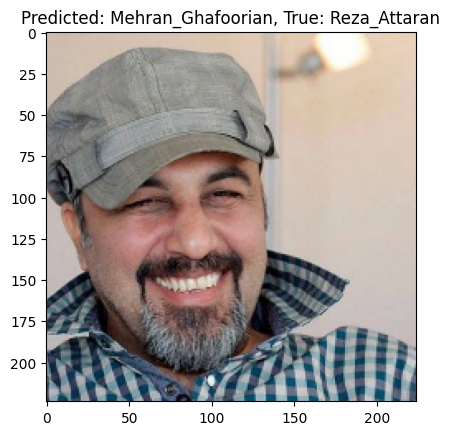

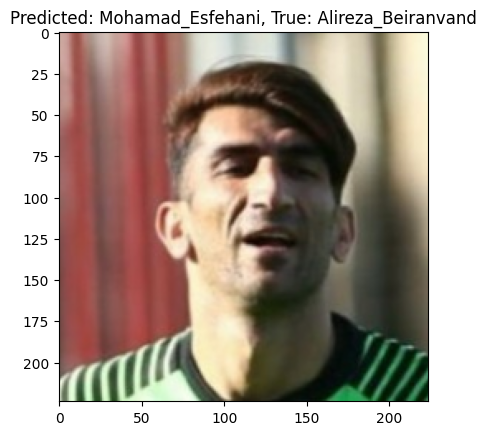

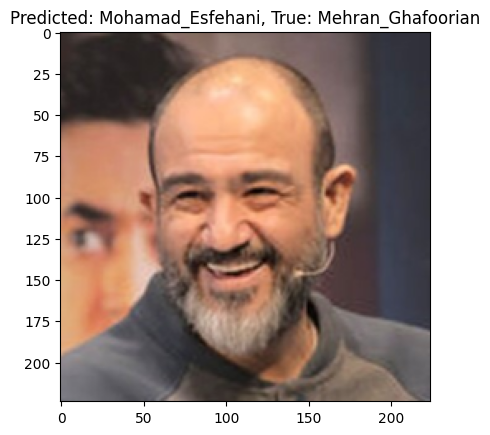

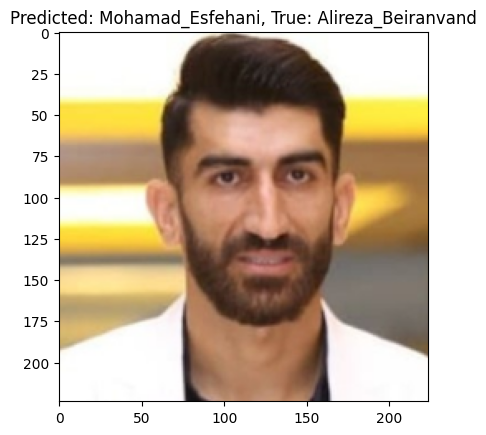

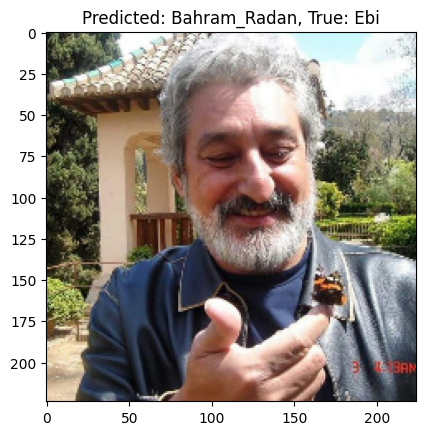

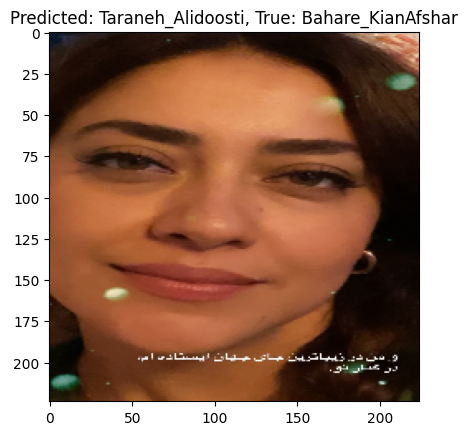

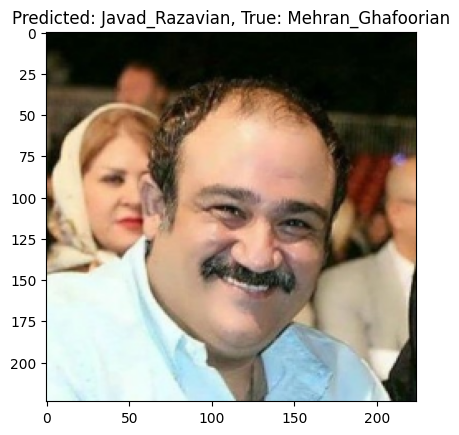

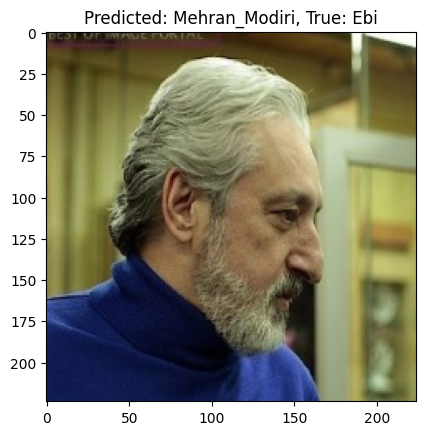

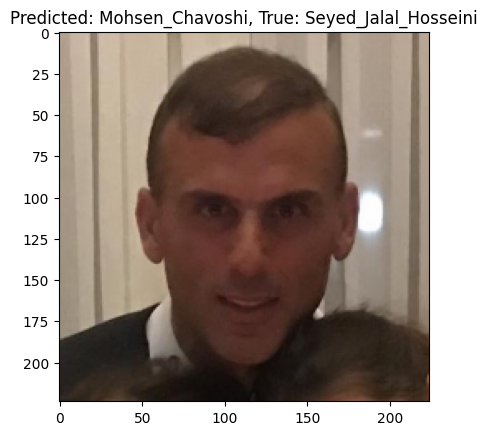

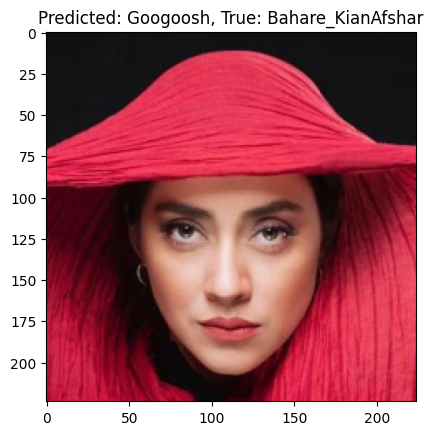

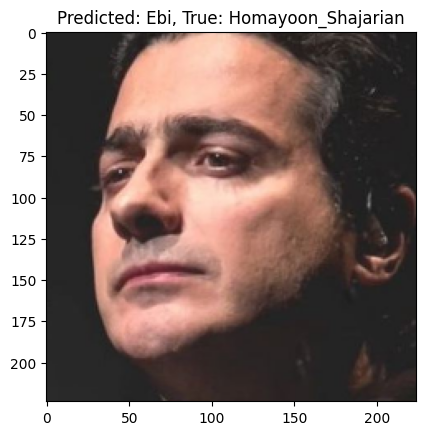

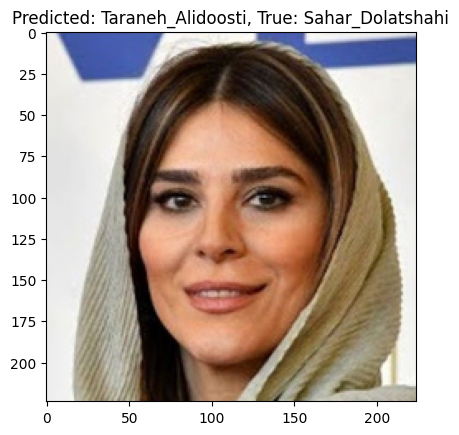

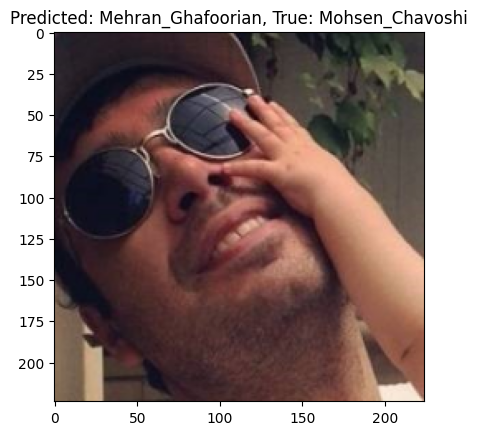

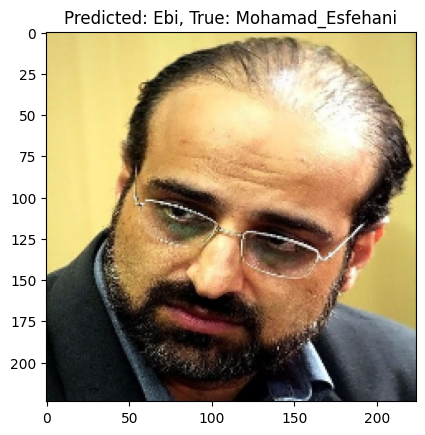

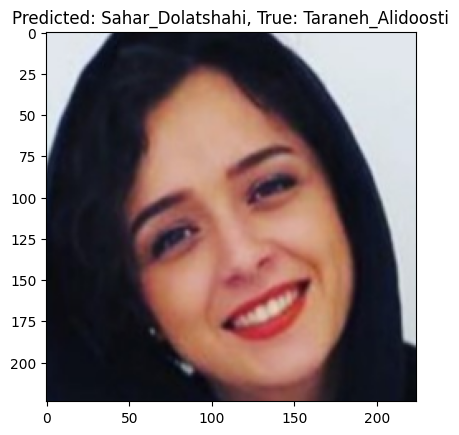

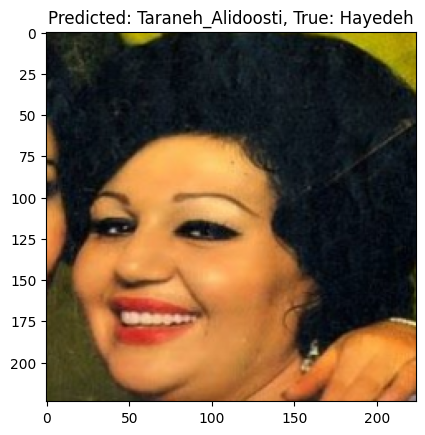

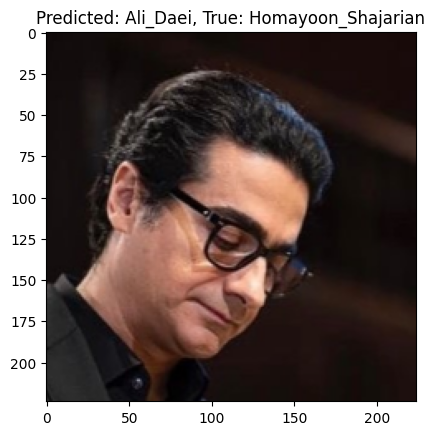

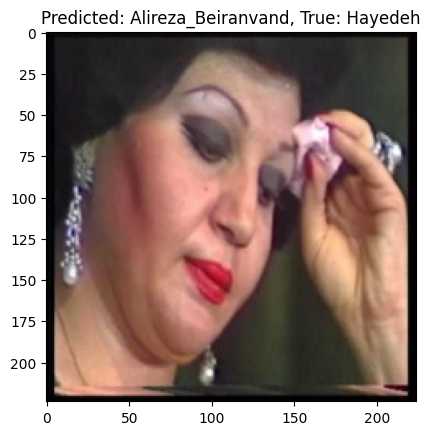

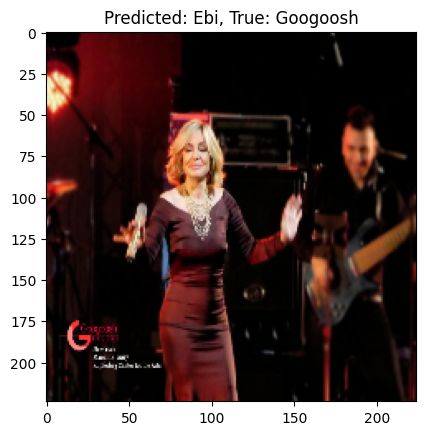

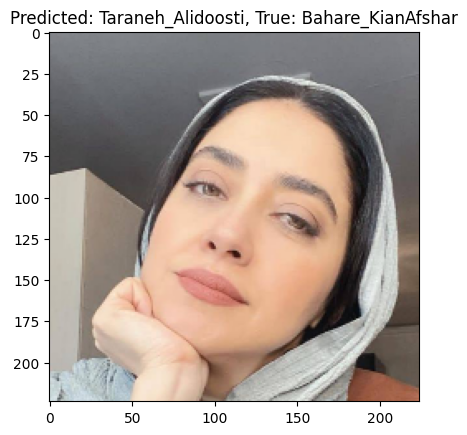

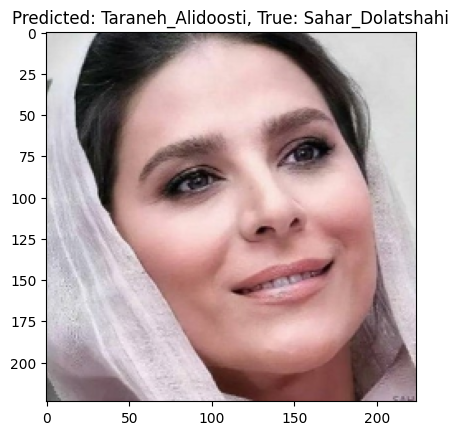

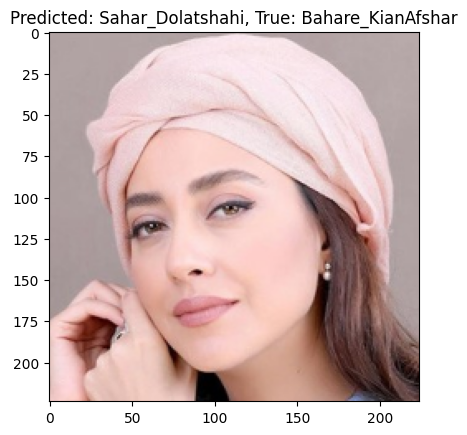

In [ ]:
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)
incorrect_indices = np.where(predicted_labels != true_labels)[0]
for idx in incorrect_indices[:]:
    denormalized_image = X_test[idx] * 255.0
    plt.imshow(denormalized_image.astype(np.uint8))
    plt.title(f'Predicted: {label_to_celebrity[predicted_labels[idx]]}, True: {label_to_celebrity[true_labels[idx]]}')
    plt.show()

Nope! our model is too weak! Let's check other ways

# **Model 2: Ensemble models (Strong)**

**Multiple models** were evaluated for this project, yet the scarcity of data, with an average of only **55** images per class for training, posed a significant challenge. Moreover, the absence of robust computational resources such as **GPU and RAM** exacerbated the difficulty of the task. Consequently, besides leveraging **transfer learning** techniques, **innovative** approaches were required to design an effective model under resource constraints.

## **Ensemble Model Configuration and Development**

### **Define and Configure Base Models**


In this cell, we define the foundational elements of our ensemble model by initializing three popular convolutional neural networks: ResNet50, InceptionV3, and MobileNetV2. These networks are loaded with weights pre-trained on the ImageNet dataset, which provides a rich set of features learned from a vast variety of images. For our task:

- **ResNet50** is known for its depth and residual connections, allowing it to learn rich feature hierarchies.
- **InceptionV3** applies filters of different sizes at each stage of the network, capturing information at various scales.
- **MobileNetV2** utilizes depthwise separable convolutions, making it efficient and lightweight, ideal for environments with limited computational resources.

**Layer Freezing**: To retain the learned features and prevent overfitting, we freeze all the layers of these models except for the top few. This ensures that the bulk of the pre-trained networks remains unchanged, while only a small fraction is fine-tuned.

**Fine-Tuning**: We unfreeze the last 10 layers of each model. This allows the networks to adapt more specifically to the nuances of our dataset, tuning the most abstract feature representations to better suit face recognition tasks.

**Input Layer Definition**: We define a common input layer that will feed into each of the base models, ensuring that they all process the same input data.

**Output Processing and Pooling**: Each model's output is passed through a Global Average Pooling layer, which reduces the dimensionality and focuses on the most essential features, preventing overfitting and reducing computational load.

**Merging Outputs**: The outputs of the pooling layers are then concatenated. This step integrates diverse aspects of the features extracted by each base model, forming a comprehensive feature set that captures a wide array of facial characteristics.

**Dense and Dropout Layers**: After merging the features from the base models, we add dense layers to interpret these features and provide the capability to learn non-linear combinations of them. The dense layers are designed with 128 and 64 neurons, respectively, and include ReLU activation to introduce non-linearity. A dropout layer with a rate of 0.5 follows the dense layers, which helps in reducing overfitting by randomly omitting a subset of features during training.
  
**Output Layer**: The final layer is a softmax layer with a number of neurons equal to the number of classes (celebrities) we wish to recognize. This layer outputs a probability distribution over the classes, predicting which celebrity a given face most likely represents.


In [ ]:
# Define base models
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(target_width, target_height, 3))
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(target_width, target_height, 3))
base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(target_width, target_height, 3))

# Freeze layers of base models
for model in (base_model_resnet, base_model_inception, base_model_mobilenet):
    for layer in model.layers:
        layer.trainable = False

# Unfreeze top layers of base models
for model in (base_model_resnet, base_model_inception, base_model_mobilenet):
    for layer in model.layers[:-10]:  # Unfreeze all layers except the last 10
        layer.trainable = True

# Define input layer
input_layer = Input(shape=(target_width, target_height, 3))

# Obtain outputs of base models
output_resnet = base_model_resnet(input_layer)
output_inception = base_model_inception(input_layer)
output_mobilenet = base_model_mobilenet(input_layer)

# Apply global average pooling to base model outputs
output_resnet_pooled = GlobalAveragePooling2D()(output_resnet)
output_inception_pooled = GlobalAveragePooling2D()(output_inception)
output_mobilenet_pooled = GlobalAveragePooling2D()(output_mobilenet)

# Concatenate pooled outputs
merged_output = Concatenate()([output_resnet_pooled, output_inception_pooled, output_mobilenet_pooled])

# Add additional layers for classification
x = Dense(128, activation='relu')(merged_output)

x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create model
ensemble_model = Model(inputs=input_layer, outputs=predictions)

9406464/9406464 [==============================] - 0s 0us/step


### **Model Compilation**

The ensemble model is compiled with the Adam optimizer, which is an extension to stochastic gradient descent that has been empirically shown to handle sparse gradients on noisy problems. We use a learning rate of 0.0001 to ensure smooth convergence. The loss function used is categorical crossentropy, suitable for multi-class classification tasks, and accuracy is tracked as the performance metric.

In [ ]:
ensemble_model.summary()

ensemble_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_4[0][0]']             
                                                          2                                       
                                                                                                  
 inception_v3 (Functional)   (None, 5, 5, 2048)           2180278   ['input_4[0][0]']             
                                                          4                                       
                                                                                              

### **Callbacks Configuration and Model Training**

EarlyStopping monitors the validation accuracy and halts training after 75 epochs without improvement, ensuring efficient use of resources by preventing overfitting. The ModelCheckpoint saves the model at its best performance state based on the highest validation accuracy. These callbacks are added to the training process to enhance model performance and save computational resources. The model is trained using the training set with specified epochs and batch size, and validation is performed using a separate validation set.

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=75, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/AI/ML-Fall2023/project/github/models/ensemblev9',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)
callbacks = [early_stopping, model_checkpoint]

In [ ]:
history = ensemble_model.fit(X_train, y_train,
                    epochs=225,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

ensemble_model.save_weights('/content/drive/MyDrive/AI/ML-Fall2023/project/github/models/ensemblev9_final')

Epoch 1/225
61/61 [==============================] - ETA: 0s - loss: 2.5469 - accuracy: 0.1973
Epoch 1: val_accuracy improved from -inf to 0.31765, saving model to /content/drive/MyDrive/AI/ML-Fall2023/project/github/models/ensemblev9
61/61 [==============================] - 263s 2s/step - loss: 2.5469 - accuracy: 0.1973 - val_loss: 2.4093 - val_accuracy: 0.3176
Epoch 2/225
61/61 [==============================] - ETA: 0s - loss: 1.4469 - accuracy: 0.5530
Epoch 2: val_accuracy improved from 0.31765 to 0.56471, saving model to /content/drive/MyDrive/AI/ML-Fall2023/project/github/models/ensemblev9
61/61 [==============================] - 126s 2s/step - loss: 1.4469 - accuracy: 0.5530 - val_loss: 1.6808 - val_accuracy: 0.5647
Epoch 3/225
61/61 [==============================] - ETA: 0s - loss: 0.7526 - accuracy: 0.7653
Epoch 3: val_accuracy improved from 0.56471 to 0.62353, saving model to /content/drive/MyDrive/AI/ML-Fall2023/project/github/models/ensemblev9
61/61 [======================

Due to limited GPU resources, training was prematurely stopped at epoch 125 of 256, and it records the best performance up to that point.

### **Model Performance Plotting and Evaluation**

In [ ]:
import pickle

# Save the history variable
with open('/content/drive/MyDrive/AI/ML-Fall2023/project/github/models/ensemblev9_final_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)


In [ ]:
with open('/content/drive/MyDrive/AI/ML-Fall2023/project/github/models/ensemblev9_final_history.pkl', 'rb') as file:
    history1 = pickle.load(file)


we plot two graphs: one for **accuracy** and the other for **loss**.
The training and validation accuracies and losses per epoch are displayed, providing insights into the model's learning and its generalization over unseen data. The performance plots help in identifying overfitting or underfitting by comparing training and validation metrics.

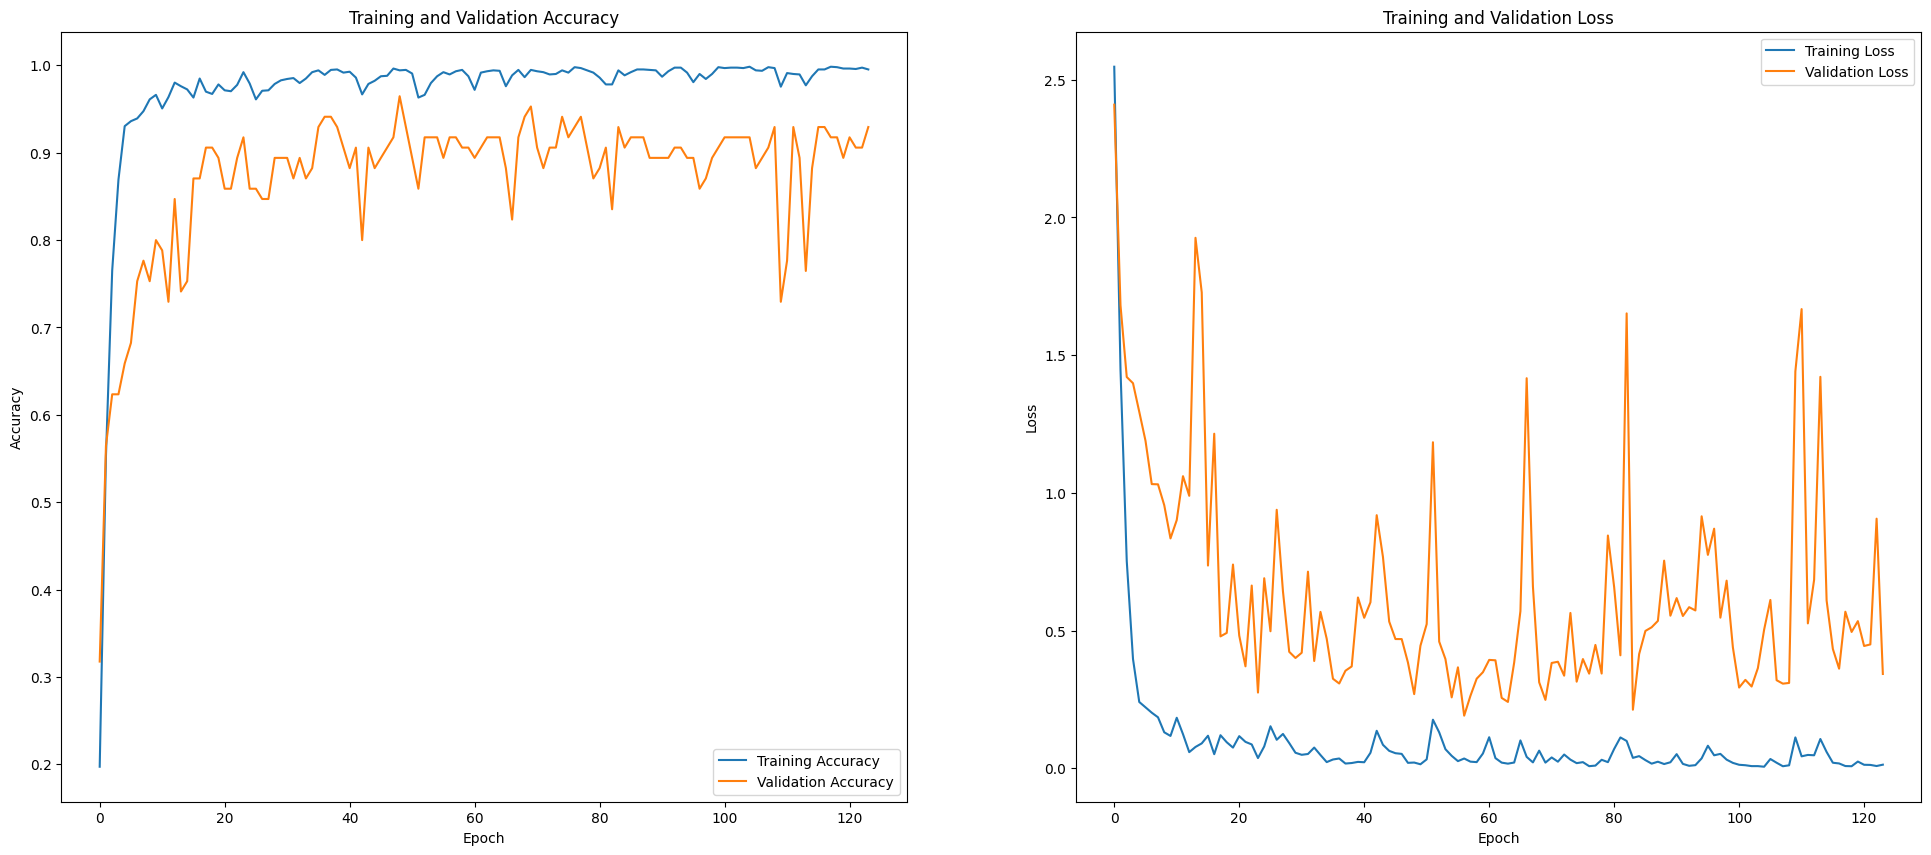

In [ ]:
plt.figure(figsize=(24, 10))

# Plot Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

because of the lack of resources (limited GPU!) our training stopped at epoch **125**/256 (even 256 was not much high epochs and higher epochs were needed (1000)) and we have saved version of our  best model till that time
 at epoch 30.

### **Model Loading and Performance Testing on unseen data**

In [ ]:
checkpoint_path  = "models/ensemblev9"

In [ ]:
ensemble_model.load_weights(checkpoint_path)

In [ ]:
train_loss, train_accuracy = ensemble_model.evaluate(X_train, y_train)
print(f'train Accuracy: {train_accuracy * 100:.2f}%')

61/61 [==============================] - 12s 194ms/step - loss: 1.6589e-04 - accuracy: 1.0000
train Accuracy: 100.00%


In [ ]:
val_loss, val_accuracy = ensemble_model.evaluate(X_val, y_val)
print(f'val Accuracy: {val_accuracy * 100:.2f}%')

3/3 [==============================] - 1s 159ms/step - loss: 0.2696 - accuracy: 0.9647
val Accuracy: 96.47%


In [ ]:
test_loss, test_accuracy = ensemble_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

3/3 [==============================] - 6s 3s/step - loss: 0.4822 - accuracy: 0.9070
Test Accuracy: 90.70%


it seems pretty nice! 🔥

let's checkout our worng predictions

In [ ]:
predictions = ensemble_model.predict(X_train)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_train, axis=1)
incorrect_indices = np.where(predicted_labels != true_labels)[0]
for idx in incorrect_indices[:]:
    denormalized_image = X_train[idx] * 255.0
    plt.imshow(denormalized_image.astype(np.uint8))
    plt.title(f'Predicted: {label_to_celebrity[predicted_labels[idx]]}, True: {label_to_celebrity[true_labels[idx]]}')
    plt.show()

3/3 [==============================] - 0s 206ms/step


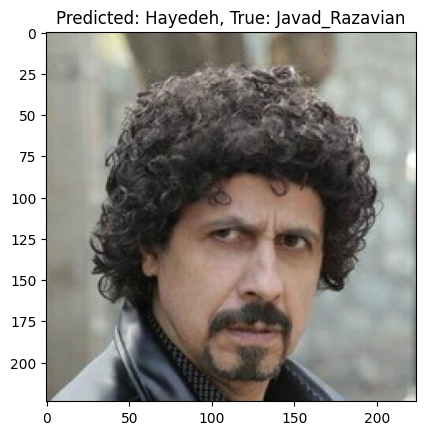

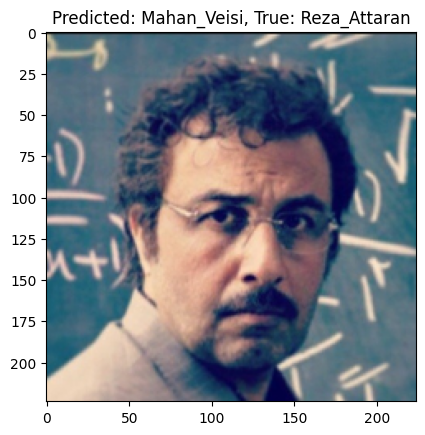

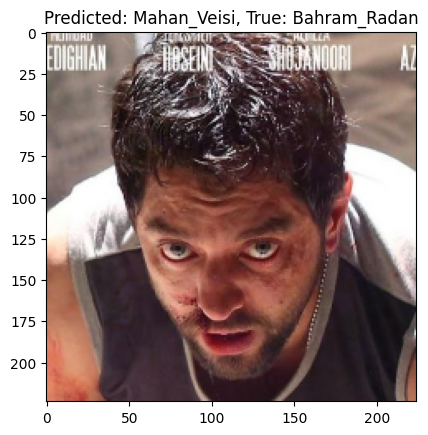

In [ ]:
predictions = ensemble_model.predict(X_val)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_val, axis=1)
incorrect_indices = np.where(predicted_labels != true_labels)[0]
for idx in incorrect_indices[:]:
    denormalized_image = X_val[idx] * 255.0
    plt.imshow(denormalized_image.astype(np.uint8))
    plt.title(f'Predicted: {label_to_celebrity[predicted_labels[idx]]}, True: {label_to_celebrity[true_labels[idx]]}')
    plt.show()

As observed from the incorrectly predicted unseen images, even the false predictions share some similarities with the actual person, such as gender, skin tone, or hair type. These misclassifications highlight the potential for improvement with a larger dataset, as the current average of 55 images per class is insufficient. Additionally, better computational resources, including more RAM and extended GPU usage, could enhance model performance.

### **test on real images in drive**

In [ ]:
cd github

/content/drive/MyDrive/AI/ML-Fall2023/project/github


In [ ]:
ls

augmented_dataset_final1/  augmented_dataset_final2/  dataset/  extra/  models/  test/


In [ ]:
model_path = 'models/ensemblev9'  # Adjust the path accordingly
model = load_model(model_path)

In [ ]:
def display_image(img_path):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

Original Image:


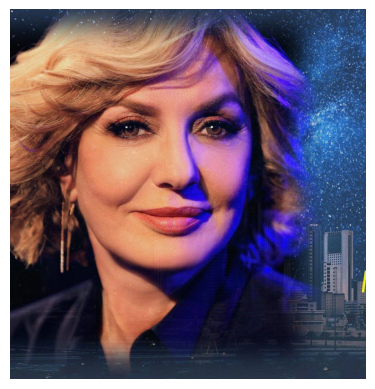

In [ ]:
image_path = 'test/Copy of 18209233_740059809501542_7500910183230757392_o.jpg'  # Replace with the path to your image
# Display the original image
print("Original Image:")
display_image(image_path)

In [ ]:
# Function to preprocess the image
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values between 0 and 1
    return img_array# Preprocess the image
preprocessed_img = preprocess_image(image_path)

In [ ]:
# Make predictions
predictions = ensemble_model.predict(preprocessed_img)

1/1 [==============================] - 2s 2s/step


In [ ]:
predictions

array([[8.2418190e-14, 2.3915030e-14, 6.3825632e-21, 4.8387776e-11,
        1.7068284e-16, 9.9563709e-14, 2.4716059e-17, 1.5887126e-13,
        1.4038549e-15, 1.5331117e-15, 6.9925554e-17, 1.6142397e-20,
        5.2144963e-17, 7.5482812e-16, 2.8694187e-19, 1.0000000e+00,
        3.5087622e-17, 1.4823235e-17]], dtype=float32)

In [ ]:
# Get the predicted class label
predicted_class_index = np.argmax(predictions)

In [ ]:
predicted_class_index

15

In [ ]:
predicted_class_label = label_to_celebrity[predicted_class_index]

print("Predicted Class:", predicted_class_label)

Predicted Class: Googoosh
